In [3]:
# Install dependencies for the script
!pip install --quiet numpy pandas matplotlib logomaker biopython

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import logomaker
from collections import defaultdict
from Bio.Data import IUPACData

# =============================================================
# 1. Imports and configuration
# =============================================================
INPUT_FILE = "2ongcealigned.cif"  # All proteins should be aligned in a single .cif file
PROTEIN_OF_INTEREST = "2ONG_C".strip().upper()
ERROR_THRESHOLD = 4.0
HARDEST_FIRST = True
DELTA = "Δ"
FREQ_CUTOFF = 0.15

# =============================================================
# 1b. Output directory setup
# =============================================================
OUTPUT_DIR = "StructuralAlignmentOut"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Normalized output filenames
OUTPUT_ASSIGNMENTS = os.path.join(OUTPUT_DIR, "residue_assignments.csv")
DELTA_SUMMARY_OUT = os.path.join(
    OUTPUT_DIR,
    f"group_delta_summary_freq_ge_{str(FREQ_CUTOFF).replace('.', 'p')}.csv"
)

# =============================================================
# 2. Grouping options (dynamic, merged labels allowed)
# =============================================================
# GROUP_MODE:
#   - "grouped": use GROUP_REGEX to extract a token from the protein id, then map via GROUP_SPEC
#   - "all":     treat all proteins as one group "All"
GROUP_MODE = "grouped"  # or "all"
GROUP_REGEX = r".*_([A-Za-z]+)$"   # captures trailing token after underscore

# Map suffix tokens to human labels. Multiple tokens may map to the same label.
# Example: C and M collapse to "Monocyclic"; B and T collapse to "Bicyclic"; L -> "Linear".
GROUP_SPEC = [
    ("L", "Linear"),
    ("C", "Monocyclic"),
]

# Derived mappings and soft validations
REGEX_MAP = {tok: name for tok, name in GROUP_SPEC}
ORDERED_LABELS = [name for _, name in GROUP_SPEC]  # may contain duplicates by design

# Helper: unique in order
_def_seen = set()
ORDERED_LABELS_UNIQUE = []
for lbl in ORDERED_LABELS:
    if lbl not in _def_seen:
        ORDERED_LABELS_UNIQUE.append(lbl)
        _def_seen.add(lbl)

# TARGET_MODE:
#   - "manual": use MANUAL_RESIDUES below
#   - "all":    use all residue numbers present in the reference protein
TARGET_MODE = "manual"  # or "all"

# Manually specified residues (used when TARGET_MODE = "manual")
MANUAL_RESIDUES = [
    63, 315, 324, 345, 348, 349, 352, 353, 356, 427, 430, 452, 453, 454,
    458, 492, 493, 496, 499, 500, 502, 503, 504, 507, 509, 512, 573,
    577, 578, 579, 581, 582
]

# 3-letter to single letter AA mapping
AA3_TO_1 = {k.upper(): v for k, v in IUPACData.protein_letters_3to1.items()}
AA3_TO_1.update({'SEC': 'U', 'PYL': 'O'})  # Include uncommon amino acids

# =============================================================
# 3. Plot configuration (fonts + logo colour + chunking readability)
#    All size values specified in centimeters (cm)
# =============================================================
# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif', 'serif']

# Sequence-logo colour scheme (logomaker built-ins: 'chemistry', 'hydrophobicity', 'charge', 'monochrome')
LOGO_COLOR_SCHEME = 'chemistry'

# Readability of sequence logos (units: cm)
MAX_POSITIONS_PER_FIG = 40   # alignment positions per logo figure (chunk size)
MIN_GLOBAL_FREQ = 0.02       # minimum AA frequency to appear in logo 
WIDTH_PER_POS_CM = 0.7       # cm added per position to figure width
BASE_WIDTH_CM = 5.0          # base figure width (cm)
FIG_HEIGHT_CM = 10.0         # figure height (cm)
DPI = 400                    # saved figure resolution
XTICK_LABEL_ROT = 90         # x-axis tick rotation (degrees)

# Conversion helper: centimeters to inches for Matplotlib
CM_TO_IN = 1.0 / 2.54

# Save or not save PNGs of sequence logos
SAVE_LOGO_PNG = False

# =============================================================
# 3b. Quick group preview (headers only)
# =============================================================

def _scan_protein_ids(path: str):
    prots = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("data_"):
                prots.append(line[len("data_"):].strip().upper())
    return prots


def _group_label_from_id(pid: str) -> str:
    if GROUP_MODE == "all":
        return "All"
    m = re.match(GROUP_REGEX, pid)
    if m:
        token = m.group(1)
        return REGEX_MAP.get(token, token)
    return "Unassigned"

# Run the preview
_all_ids = _scan_protein_ids(INPUT_FILE)
print("\n=== Group Preview (from file headers only) ===")
if not _all_ids:
    print("No 'data_' blocks found in the input file.")
else:
    if GROUP_MODE == "all":
        print(f"GROUP_MODE='all' -> single group 'All' (n={len(_all_ids)})")
        for p in sorted(_all_ids):
            print(f"  - {p}")
    else:
        _preview_groups = {}
        for pid in _all_ids:
            g = _group_label_from_id(pid)
            _preview_groups.setdefault(g, []).append(pid)

        total_named = sum(len(_preview_groups[g]) for g in _preview_groups if g != "Unassigned")
        print(f"Total proteins: {len(_all_ids)} | Grouped (named): {total_named}")
        for g in sorted(_preview_groups):
            members = sorted(_preview_groups[g])
            print(f"\nGroup: {g}  (n={len(members)})")
            for m in members:
                print(f"  - {m}")


=== Group Preview (from file headers only) ===
Total proteins: 88 | Grouped (named): 88

Group: Linear  (n=59)
  - A0A059SVB0_L
  - A0A068B0N9_L
  - A0A097ZLN9_L
  - A0A097ZLP5_L
  - A0A097ZLS9_L
  - A0A140KFH3_L
  - A0A1Q1N939_L
  - A0A2R3ZE38_L
  - A0A2R3ZE39_L
  - A0A345BJ04_L
  - A0A3G9EWY9_L
  - A0A4Y5QWA6_L
  - A0A4Y5QZ62_L
  - A0A5B9G8E4_L
  - A0A6C0M6B5_L
  - A0A7G8EIM4_L
  - A0A7L7S5P2_L
  - A0A7L7S5U1_L
  - A0A7L7T499_L
  - A0A7L7TAQ2_L
  - ATY48639_L
  - B1NA83_L
  - B1NA84_L
  - B6F137_L
  - C0KWV5_L
  - C0KWV7_L
  - C0KY88_L
  - C0PPR1_L
  - D4N3A0_L
  - D4N3A1_L
  - D5SL78_L
  - DINCTG000_NP1212847_L
  - F2XF93_L
  - F2XFA6_L
  - F8TWD1_L
  - F8TWD2_L
  - G5CV39_L
  - H6UQ81_L
  - H6WBC5_L
  - HMOCHR44410_L
  - J7HWK5_L
  - P0CV94_L
  - P0CV95_L
  - Q1XBU5_L
  - Q2XSC5_L
  - Q5SBP3_L
  - Q675L2_L
  - Q6ZH94_L
  - Q84UV0_L
  - Q8H2B4_L
  - Q96376_L
  - Q9SPN0_L
  - Q9SPN1_L
  - R4I6X2_L
  - SLECTG065_NP871_L
  - SLECTG127_NP665_L
  - SLECTG240_NP1756_L
  - U5PZT6_L
  - VO

Saved residue assignments to: StructuralAlignmentOut\residue_assignments.csv

=== Group Summary ===
Total groups detected: 2

Group: Linear  (n=59)
  - A0A059SVB0_L
  - A0A068B0N9_L
  - A0A097ZLN9_L
  - A0A097ZLP5_L
  - A0A097ZLS9_L
  - A0A140KFH3_L
  - A0A1Q1N939_L
  - A0A2R3ZE38_L
  - A0A2R3ZE39_L
  - A0A345BJ04_L
  - A0A3G9EWY9_L
  - A0A4Y5QWA6_L
  - A0A4Y5QZ62_L
  - A0A5B9G8E4_L
  - A0A6C0M6B5_L
  - A0A7G8EIM4_L
  - A0A7L7S5P2_L
  - A0A7L7S5U1_L
  - A0A7L7T499_L
  - A0A7L7TAQ2_L
  - ATY48639_L
  - B1NA83_L
  - B1NA84_L
  - B6F137_L
  - C0KWV5_L
  - C0KWV7_L
  - C0KY88_L
  - C0PPR1_L
  - D4N3A0_L
  - D4N3A1_L
  - D5SL78_L
  - DINCTG000_NP1212847_L
  - F2XF93_L
  - F2XFA6_L
  - F8TWD1_L
  - F8TWD2_L
  - G5CV39_L
  - H6UQ81_L
  - H6WBC5_L
  - HMOCHR44410_L
  - J7HWK5_L
  - P0CV94_L
  - P0CV95_L
  - Q1XBU5_L
  - Q2XSC5_L
  - Q5SBP3_L
  - Q675L2_L
  - Q6ZH94_L
  - Q84UV0_L
  - Q8H2B4_L
  - Q96376_L
  - Q9SPN0_L
  - Q9SPN1_L
  - R4I6X2_L
  - SLECTG065_NP871_L
  - SLECTG127_NP665_L
  - SL

,Residue Position,Linear,Δ Linear,Monocyclic,Δ Monocyclic,Specified Residue
0,63,Y:0.37,Y:Δ0.45,Y:0.82,Y:Δ0.45,Y
1,315,R:0.98,R:Δ0.02,R:1.00,R:Δ0.02,R
2,324,W:0.81,W:Δ0.04,W:0.86,W:Δ0.04,W
3,345,I:0.53,I:Δ0.13,"I:0.39, N:0.25","N:Δ0.18, I:Δ0.13",N
4,348,"I:0.46, V:0.24","V:Δ0.20, I:Δ0.15",I:0.61,I:Δ0.15,I
5,349,"T:0.47, Y:0.44","Y:Δ0.44, T:Δ0.38",T:0.86,T:Δ0.38,T
6,352,D:1.00,D:Δ0.00,D:1.00,D:Δ0.00,D
7,353,D:1.00,D:Δ0.00,D:1.00,D:Δ0.00,D
8,356,D:0.97,D:Δ0.03,D:1.00,D:Δ0.03,D
9,427,"Y:0.51, F:0.44","F:Δ0.37, Y:Δ0.35",Y:0.86,Y:Δ0.35,Y


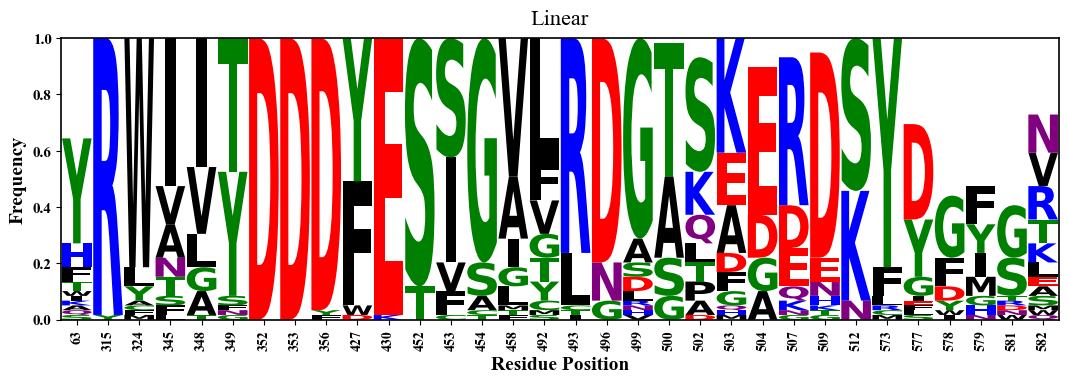

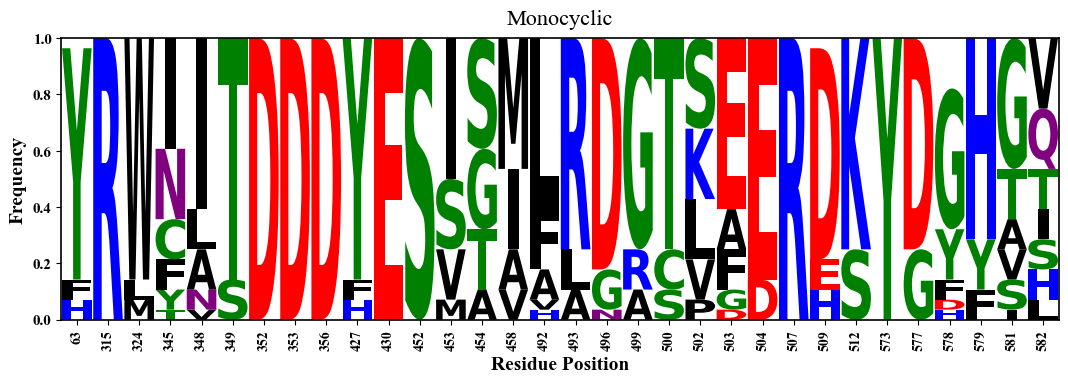


Protein: A0A059SVB0_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
0,63,Y,Y,57.0,0.773517,assigned
1,315,R,R,302.0,0.460394,assigned
2,324,W,W,311.0,0.717388,assigned
3,345,N,I,332.0,0.397378,assigned
4,348,I,V,335.0,0.520370,assigned
5,349,T,G,336.0,0.472274,assigned
6,352,D,D,339.0,0.364808,assigned
7,353,D,D,340.0,0.393529,assigned
8,356,D,D,343.0,0.529765,assigned
9,427,Y,Y,414.0,1.240784,assigned



Protein: A0A068B0N9_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
32,63,Y,Y,70.0,1.208181,assigned
33,315,R,R,327.0,0.428109,assigned
34,324,W,W,336.0,1.594735,assigned
35,345,N,V,357.0,0.678484,assigned
36,348,I,L,360.0,0.796190,assigned
37,349,T,T,361.0,0.570044,assigned
38,352,D,D,364.0,0.120412,assigned
39,353,D,D,365.0,0.348122,assigned
40,356,D,D,368.0,0.334748,assigned
41,427,Y,Y,439.0,0.736319,assigned



Protein: A0A097ZLN9_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
64,63,Y,-,NaN,4.988248,no_unused_within_threshold
65,315,R,R,301.0,1.222208,assigned
66,324,W,W,310.0,1.661186,assigned
67,345,N,I,331.0,1.447446,assigned
68,348,I,I,334.0,1.354686,assigned
69,349,T,Y,335.0,1.254124,assigned
70,352,D,D,338.0,0.781498,assigned
71,353,D,D,339.0,0.747912,assigned
72,356,D,D,342.0,0.806653,assigned
73,427,Y,F,413.0,1.310641,assigned



Protein: A0A097ZLP5_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
96,63,Y,F,28.0,1.037283,assigned
97,315,R,R,280.0,0.846930,assigned
98,324,W,W,289.0,0.740007,assigned
99,345,N,I,310.0,1.345520,assigned
100,348,I,A,313.0,1.254326,assigned
101,349,T,S,314.0,1.178956,assigned
102,352,D,D,317.0,0.345223,assigned
103,353,D,D,318.0,0.181846,assigned
104,356,D,D,321.0,0.200910,assigned
105,427,Y,Y,392.0,1.069620,assigned



Protein: A0A097ZLS9_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
128,63,Y,-,NaN,5.011086,no_unused_within_threshold
129,315,R,R,292.0,0.570892,assigned
130,324,W,W,301.0,1.299136,assigned
131,345,N,I,322.0,1.161697,assigned
132,348,I,V,325.0,1.367334,assigned
133,349,T,Y,326.0,0.962075,assigned
134,352,D,D,329.0,0.685835,assigned
135,353,D,D,330.0,0.433264,assigned
136,356,D,Y,333.0,1.166964,assigned
137,427,Y,F,406.0,1.130923,assigned



Protein: A0A0D3ML99_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
160,63,Y,Y,53.0,1.443733,assigned
161,315,R,R,298.0,0.705664,assigned
162,324,W,W,307.0,1.321202,assigned
163,345,N,T,328.0,0.990463,assigned
164,348,I,I,331.0,0.833376,assigned
165,349,T,T,332.0,0.858695,assigned
166,352,D,D,335.0,0.475826,assigned
167,353,D,D,336.0,0.527657,assigned
168,356,D,D,339.0,0.827510,assigned
169,427,Y,Y,410.0,0.782166,assigned



Protein: A0A0F6PMD0_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
192,63,Y,Y,60.0,1.084829,assigned
193,315,R,R,313.0,0.591028,assigned
194,324,W,W,322.0,0.523696,assigned
195,345,N,N,343.0,0.437569,assigned
196,348,I,I,346.0,0.454375,assigned
197,349,T,T,347.0,0.393245,assigned
198,352,D,D,350.0,0.385597,assigned
199,353,D,D,351.0,0.554015,assigned
200,356,D,D,354.0,0.540864,assigned
201,427,Y,Y,425.0,1.081039,assigned



Protein: A0A140KFH3_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
224,63,Y,-,NaN,4.590230,no_unused_within_threshold
225,315,R,R,293.0,1.893344,assigned
226,324,W,W,302.0,2.088038,assigned
227,345,N,I,323.0,1.860832,assigned
228,348,I,I,326.0,1.719221,assigned
229,349,T,Y,327.0,1.544926,assigned
230,352,D,D,330.0,0.973756,assigned
231,353,D,D,331.0,1.215142,assigned
232,356,D,D,334.0,1.196916,assigned
233,427,Y,F,405.0,1.343882,assigned



Protein: A0A1C9J6A7_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
256,63,Y,Y,58.0,0.992594,assigned
257,315,R,R,306.0,0.311423,assigned
258,324,W,W,315.0,0.937760,assigned
259,345,N,I,336.0,0.439856,assigned
260,348,I,I,339.0,0.415106,assigned
261,349,T,T,340.0,0.226002,assigned
262,352,D,D,343.0,0.462565,assigned
263,353,D,D,344.0,0.598365,assigned
264,356,D,D,347.0,0.360179,assigned
265,427,Y,Y,419.0,0.763636,assigned



Protein: A0A1Q1N939_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
288,63,Y,Y,61.0,1.477321,assigned
289,315,R,R,309.0,0.611095,assigned
290,324,W,F,318.0,1.144974,assigned
291,345,N,N,339.0,0.730981,assigned
292,348,I,V,342.0,0.604163,assigned
293,349,T,T,343.0,0.537965,assigned
294,352,D,D,346.0,0.413937,assigned
295,353,D,D,347.0,0.649407,assigned
296,356,D,D,350.0,1.073663,assigned
297,427,Y,Y,421.0,0.942994,assigned



Protein: A0A2R3ZE38_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
320,63,Y,-,NaN,5.320080,no_unused_within_threshold
321,315,R,R,252.0,1.143958,assigned
322,324,W,W,261.0,1.683257,assigned
323,345,N,I,282.0,1.597914,assigned
324,348,I,V,285.0,1.360192,assigned
325,349,T,Y,286.0,1.220374,assigned
326,352,D,D,289.0,0.731673,assigned
327,353,D,D,290.0,0.691409,assigned
328,356,D,D,293.0,0.838133,assigned
329,427,Y,F,364.0,1.308010,assigned



Protein: A0A2R3ZE39_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
352,63,Y,Y,67.0,1.087359,assigned
353,315,R,R,316.0,0.537298,assigned
354,324,W,W,325.0,1.639551,assigned
355,345,N,V,346.0,0.826259,assigned
356,348,I,L,349.0,0.980155,assigned
357,349,T,T,350.0,0.641299,assigned
358,352,D,D,353.0,0.124740,assigned
359,353,D,D,354.0,0.283741,assigned
360,356,D,D,357.0,0.292809,assigned
361,427,Y,Y,428.0,0.859848,assigned



Protein: A0A345BJ04_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
384,63,Y,I,35.0,3.803212,assigned
385,315,R,R,289.0,1.417900,assigned
386,324,W,W,298.0,1.092309,assigned
387,345,N,I,320.0,0.983159,assigned
388,348,I,I,323.0,0.960214,assigned
389,349,T,Y,324.0,0.795513,assigned
390,352,D,D,327.0,0.251311,assigned
391,353,D,D,328.0,0.903505,assigned
392,356,D,D,331.0,1.551132,assigned
393,427,Y,F,402.0,0.933290,assigned



Protein: A0A3G9EWY9_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
416,63,Y,-,NaN,5.149519,no_unused_within_threshold
417,315,R,R,299.0,1.109966,assigned
418,324,W,M,307.0,1.956080,assigned
419,345,N,I,329.0,1.523715,assigned
420,348,I,I,332.0,1.294866,assigned
421,349,T,Y,333.0,1.270592,assigned
422,352,D,D,336.0,0.745258,assigned
423,353,D,D,337.0,0.499734,assigned
424,356,D,D,340.0,0.545667,assigned
425,427,Y,F,411.0,0.777317,assigned



Protein: A0A481YAH7_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
448,63,Y,Y,58.0,0.927063,assigned
449,315,R,R,305.0,0.178104,assigned
450,324,W,W,314.0,0.932604,assigned
451,345,N,I,335.0,0.396385,assigned
452,348,I,I,338.0,0.370548,assigned
453,349,T,T,339.0,0.197155,assigned
454,352,D,D,342.0,0.499821,assigned
455,353,D,D,343.0,0.639364,assigned
456,356,D,D,346.0,0.333246,assigned
457,427,Y,Y,418.0,0.814657,assigned



Protein: A0A4Y5QVX4_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
480,63,Y,Y,82.0,1.967927,assigned
481,315,R,R,336.0,1.064414,assigned
482,324,W,W,345.0,0.416174,assigned
483,345,N,Y,366.0,0.502557,assigned
484,348,I,L,369.0,0.542745,assigned
485,349,T,T,370.0,0.662358,assigned
486,352,D,D,373.0,0.259019,assigned
487,353,D,D,374.0,0.411803,assigned
488,356,D,D,377.0,0.476917,assigned
489,427,Y,H,448.0,0.934128,assigned



Protein: A0A4Y5QWA6_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
512,63,Y,-,NaN,4.103441,no_unused_within_threshold
513,315,R,R,276.0,0.682601,assigned
514,324,W,W,285.0,1.536817,assigned
515,345,N,I,306.0,1.054008,assigned
516,348,I,I,309.0,1.134886,assigned
517,349,T,Y,310.0,0.984724,assigned
518,352,D,D,313.0,0.500691,assigned
519,353,D,D,314.0,0.103296,assigned
520,356,D,D,317.0,0.749628,assigned
521,427,Y,F,388.0,0.737959,assigned



Protein: A0A4Y5QZ62_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
544,63,Y,-,NaN,4.710159,no_unused_within_threshold
545,315,R,R,276.0,1.859420,assigned
546,324,W,W,285.0,2.082424,assigned
547,345,N,I,306.0,1.927436,assigned
548,348,I,I,309.0,1.718993,assigned
549,349,T,Y,310.0,1.610853,assigned
550,352,D,D,313.0,1.094282,assigned
551,353,D,D,314.0,1.253375,assigned
552,356,D,D,317.0,1.151519,assigned
553,427,Y,F,388.0,1.180110,assigned



Protein: A0A5B9G8E4_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
576,63,Y,Y,71.0,1.431641,assigned
577,315,R,R,329.0,0.371152,assigned
578,324,W,W,338.0,1.395208,assigned
579,345,N,V,359.0,0.586413,assigned
580,348,I,L,362.0,0.578889,assigned
581,349,T,T,363.0,0.417294,assigned
582,352,D,D,366.0,0.257482,assigned
583,353,D,D,367.0,0.498986,assigned
584,356,D,D,370.0,0.283834,assigned
585,427,Y,Y,441.0,0.661581,assigned



Protein: A0A6C0M6B5_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
608,63,Y,Y,57.0,2.121745,assigned
609,315,R,R,307.0,0.872899,assigned
610,324,W,W,316.0,1.407695,assigned
611,345,N,T,337.0,0.683422,assigned
612,348,I,I,340.0,0.771696,assigned
613,349,T,T,341.0,0.711670,assigned
614,352,D,D,344.0,0.374693,assigned
615,353,D,D,345.0,0.816832,assigned
616,356,D,D,348.0,1.029720,assigned
617,427,Y,Y,419.0,1.129181,assigned



Protein: A0A6P6W6H5_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
640,63,Y,Y,69.0,1.046085,assigned
641,315,R,R,320.0,0.786127,assigned
642,324,W,W,329.0,0.915649,assigned
643,345,N,F,350.0,0.377784,assigned
644,348,I,I,353.0,0.521940,assigned
645,349,T,T,354.0,0.467384,assigned
646,352,D,D,357.0,0.116974,assigned
647,353,D,D,358.0,0.351832,assigned
648,356,D,D,361.0,0.304293,assigned
649,427,Y,Y,432.0,0.745303,assigned



Protein: A0A7G8EIM4_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
672,63,Y,Y,58.0,0.851917,assigned
673,315,R,R,299.0,0.254955,assigned
674,324,W,W,308.0,1.376092,assigned
675,345,N,V,329.0,0.548264,assigned
676,348,I,L,332.0,0.710776,assigned
677,349,T,T,333.0,0.493239,assigned
678,352,D,D,336.0,0.081000,assigned
679,353,D,D,337.0,0.291983,assigned
680,356,D,D,340.0,0.154952,assigned
681,427,Y,Y,411.0,0.660758,assigned



Protein: A0A7L7S5P2_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
704,63,Y,S,21.0,1.711428,assigned
705,315,R,R,273.0,0.656758,assigned
706,324,W,W,282.0,0.381665,assigned
707,345,N,F,303.0,0.380560,assigned
708,348,I,L,306.0,0.408873,assigned
709,349,T,T,307.0,0.384647,assigned
710,352,D,D,310.0,0.334189,assigned
711,353,D,D,311.0,0.510523,assigned
712,356,D,D,314.0,0.398684,assigned
713,427,Y,F,385.0,0.913476,assigned



Protein: A0A7L7S5U1_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
736,63,Y,-,NaN,4.348593,no_unused_within_threshold
737,315,R,R,296.0,1.116703,assigned
738,324,W,W,305.0,1.644843,assigned
739,345,N,I,326.0,1.438183,assigned
740,348,I,I,329.0,1.355094,assigned
741,349,T,Y,330.0,1.213391,assigned
742,352,D,D,333.0,0.760411,assigned
743,353,D,D,334.0,0.704262,assigned
744,356,D,D,337.0,0.819560,assigned
745,427,Y,F,408.0,0.943945,assigned



Protein: A0A7L7T499_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
768,63,Y,Y,49.0,1.209313,assigned
769,315,R,R,305.0,0.920179,assigned
770,324,W,W,314.0,1.159540,assigned
771,345,N,N,335.0,0.633042,assigned
772,348,I,V,338.0,0.695941,assigned
773,349,T,T,339.0,0.617173,assigned
774,352,D,D,342.0,0.366509,assigned
775,353,D,D,343.0,0.441999,assigned
776,356,D,D,346.0,0.683653,assigned
777,427,Y,Y,417.0,0.655666,assigned



Protein: A0A7L7TAQ2_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
800,63,Y,Y,49.0,1.146644,assigned
801,315,R,R,305.0,0.747389,assigned
802,324,W,W,314.0,0.957949,assigned
803,345,N,N,335.0,0.699781,assigned
804,348,I,V,338.0,0.778212,assigned
805,349,T,T,339.0,0.677222,assigned
806,352,D,D,342.0,0.610844,assigned
807,353,D,D,343.0,0.710752,assigned
808,356,D,D,346.0,0.728157,assigned
809,427,Y,Y,417.0,0.593583,assigned



Protein: A7IZZ1_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
832,63,Y,Y,82.0,1.819812,assigned
833,315,R,R,336.0,0.755752,assigned
834,324,W,W,345.0,0.415910,assigned
835,345,N,Y,366.0,0.600589,assigned
836,348,I,L,369.0,0.710051,assigned
837,349,T,T,370.0,0.709555,assigned
838,352,D,D,373.0,0.135100,assigned
839,353,D,D,374.0,0.211551,assigned
840,356,D,D,377.0,0.305341,assigned
841,427,Y,H,448.0,0.871613,assigned



Protein: ATY48639_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
864,63,Y,Y,36.0,0.994566,assigned
865,315,R,R,295.0,0.739685,assigned
866,324,W,W,304.0,0.690184,assigned
867,345,N,V,325.0,0.347278,assigned
868,348,I,I,328.0,0.303824,assigned
869,349,T,N,329.0,0.369792,assigned
870,352,D,D,332.0,0.312604,assigned
871,353,D,D,333.0,0.544159,assigned
872,356,D,D,336.0,0.826591,assigned
873,427,Y,Y,407.0,0.686561,assigned



Protein: B0F4G4_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
896,63,Y,Y,63.0,0.600181,assigned
897,315,R,R,315.0,0.467832,assigned
898,324,W,W,324.0,0.107107,assigned
899,345,N,N,345.0,0.193572,assigned
900,348,I,I,348.0,0.228353,assigned
901,349,T,T,349.0,0.114547,assigned
902,352,D,D,352.0,0.207692,assigned
903,353,D,D,353.0,0.191951,assigned
904,356,D,D,356.0,0.321451,assigned
905,427,Y,Y,427.0,0.356306,assigned



Protein: B1NA83_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
928,63,Y,H,28.0,3.266235,assigned
929,315,R,R,285.0,1.128476,assigned
930,324,W,C,294.0,2.034448,assigned
931,345,N,I,316.0,1.676267,assigned
932,348,I,I,319.0,1.511446,assigned
933,349,T,Y,320.0,1.255407,assigned
934,352,D,D,323.0,0.855762,assigned
935,353,D,D,324.0,0.653601,assigned
936,356,D,D,327.0,1.074981,assigned
937,427,Y,F,398.0,1.558868,assigned



Protein: B1NA84_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
960,63,Y,-,NaN,4.276318,no_unused_within_threshold
961,315,R,R,315.0,1.400374,assigned
962,324,W,W,324.0,1.506524,assigned
963,345,N,I,346.0,1.603842,assigned
964,348,I,I,349.0,1.671657,assigned
965,349,T,Y,350.0,1.322735,assigned
966,352,D,D,353.0,0.734538,assigned
967,353,D,D,354.0,0.484746,assigned
968,356,D,D,357.0,0.536736,assigned
969,427,Y,F,428.0,0.793606,assigned



Protein: B6F137_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
992,63,Y,W,62.0,1.836868,assigned
993,315,R,R,307.0,1.142347,assigned
994,324,W,W,316.0,1.170218,assigned
995,345,N,A,337.0,0.963378,assigned
996,348,I,A,340.0,1.086220,assigned
997,349,T,T,341.0,1.131322,assigned
998,352,D,D,344.0,0.892505,assigned
999,353,D,D,345.0,0.816291,assigned
1000,356,D,D,348.0,0.964985,assigned
1001,427,Y,D,419.0,1.351743,assigned



Protein: C0KWV5_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1024,63,Y,Y,67.0,0.155512,assigned
1025,315,R,R,323.0,0.714726,assigned
1026,324,W,W,332.0,0.617917,assigned
1027,345,N,I,353.0,0.647272,assigned
1028,348,I,I,356.0,0.450475,assigned
1029,349,T,T,357.0,0.649124,assigned
1030,352,D,D,360.0,0.483750,assigned
1031,353,D,D,361.0,0.369298,assigned
1032,356,D,D,364.0,0.328056,assigned
1033,427,Y,Y,435.0,0.620576,assigned



Protein: C0KWV7_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1056,63,Y,Y,67.0,0.605417,assigned
1057,315,R,R,323.0,0.977141,assigned
1058,324,W,W,332.0,1.030069,assigned
1059,345,N,I,353.0,0.671738,assigned
1060,348,I,I,356.0,0.513869,assigned
1061,349,T,T,357.0,0.803207,assigned
1062,352,D,D,360.0,0.452387,assigned
1063,353,D,D,361.0,0.404542,assigned
1064,356,D,D,364.0,0.084699,assigned
1065,427,Y,Y,435.0,0.848849,assigned



Protein: C0KY88_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1088,63,Y,Y,41.0,0.793175,assigned
1089,315,R,R,295.0,0.657527,assigned
1090,324,W,W,304.0,0.745693,assigned
1091,345,N,I,325.0,0.556116,assigned
1092,348,I,A,328.0,0.531888,assigned
1093,349,T,T,329.0,0.917198,assigned
1094,352,D,D,332.0,0.535159,assigned
1095,353,D,D,333.0,0.340717,assigned
1096,356,D,D,336.0,0.179697,assigned
1097,427,Y,Y,406.0,0.759811,assigned



Protein: C0PPR1_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1120,63,Y,H,68.0,2.330521,assigned
1121,315,R,R,340.0,1.245563,assigned
1122,324,W,L,349.0,1.243486,assigned
1123,345,N,T,370.0,1.260860,assigned
1124,348,I,G,373.0,0.969577,assigned
1125,349,T,T,374.0,1.189874,assigned
1126,352,D,D,377.0,0.823839,assigned
1127,353,D,D,378.0,0.756163,assigned
1128,356,D,D,381.0,1.004985,assigned
1129,427,Y,Y,452.0,1.608279,assigned



Protein: D4N3A0_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1152,63,Y,T,35.0,3.704025,assigned
1153,315,R,R,292.0,1.253869,assigned
1154,324,W,W,301.0,1.645478,assigned
1155,345,N,I,322.0,1.449079,assigned
1156,348,I,I,325.0,1.362607,assigned
1157,349,T,Y,326.0,1.113752,assigned
1158,352,D,D,329.0,0.623328,assigned
1159,353,D,D,330.0,0.521979,assigned
1160,356,D,D,333.0,0.734503,assigned
1161,427,Y,F,404.0,1.102251,assigned



Protein: D4N3A1_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1184,63,Y,K,38.0,3.272807,assigned
1185,315,R,R,292.0,1.895368,assigned
1186,324,W,W,301.0,2.069650,assigned
1187,345,N,I,322.0,1.905554,assigned
1188,348,I,I,325.0,1.607440,assigned
1189,349,T,Y,326.0,1.375239,assigned
1190,352,D,D,329.0,0.821482,assigned
1191,353,D,D,330.0,0.690501,assigned
1192,356,D,D,333.0,0.807965,assigned
1193,427,Y,F,404.0,1.440723,assigned



Protein: D5SL78_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1216,63,Y,-,NaN,5.390604,no_unused_within_threshold
1217,315,R,Y,44.0,2.850537,assigned
1218,324,W,Y,55.0,1.433412,assigned
1219,345,N,L,72.0,1.688365,assigned
1220,348,I,T,75.0,1.885424,assigned
1221,349,T,F,76.0,1.790389,assigned
1222,352,D,D,79.0,1.904661,assigned
1223,353,D,D,80.0,1.909161,assigned
1224,356,D,F,82.0,3.413132,assigned
1225,427,Y,W,150.0,3.269312,assigned



Protein: DINCTG000_NP1212847_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2464,63,Y,F,83.0,1.948396,assigned
2465,315,R,R,327.0,0.368653,assigned
2466,324,W,Y,336.0,1.102665,assigned
2467,345,N,T,357.0,0.931980,assigned
2468,348,I,A,360.0,1.273297,assigned
2469,349,T,T,361.0,0.855576,assigned
2470,352,D,D,364.0,0.734018,assigned
2471,353,D,D,365.0,0.945233,assigned
2472,356,D,D,368.0,1.059347,assigned
2473,427,Y,Y,439.0,1.334409,assigned



Protein: F2XF93_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1248,63,Y,H,68.0,2.020927,assigned
1249,315,R,R,341.0,0.912848,assigned
1250,324,W,L,350.0,1.484530,assigned
1251,345,N,S,371.0,1.039933,assigned
1252,348,I,G,374.0,0.940296,assigned
1253,349,T,T,375.0,0.922586,assigned
1254,352,D,D,378.0,0.826961,assigned
1255,353,D,D,379.0,0.774176,assigned
1256,356,D,D,382.0,1.237776,assigned
1257,427,Y,Y,453.0,1.925936,assigned



Protein: F2XFA6_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1280,63,Y,H,68.0,1.756093,assigned
1281,315,R,R,341.0,1.237302,assigned
1282,324,W,L,350.0,1.513587,assigned
1283,345,N,S,371.0,1.064017,assigned
1284,348,I,G,374.0,0.940046,assigned
1285,349,T,T,375.0,0.999004,assigned
1286,352,D,D,378.0,0.829429,assigned
1287,353,D,D,379.0,0.735469,assigned
1288,356,D,D,382.0,1.047630,assigned
1289,427,Y,Y,453.0,1.958770,assigned



Protein: F8TWD1_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1312,63,Y,T,40.0,2.304768,assigned
1313,315,R,R,290.0,1.264901,assigned
1314,324,W,W,299.0,1.686125,assigned
1315,345,N,V,320.0,1.352271,assigned
1316,348,I,I,323.0,1.312712,assigned
1317,349,T,Y,324.0,1.190419,assigned
1318,352,D,D,327.0,0.769354,assigned
1319,353,D,D,328.0,0.806021,assigned
1320,356,D,D,331.0,0.867390,assigned
1321,427,Y,F,402.0,1.213263,assigned



Protein: F8TWD2_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1344,63,Y,Y,11.0,0.856539,assigned
1345,315,R,R,255.0,0.450904,assigned
1346,324,W,W,264.0,1.597482,assigned
1347,345,N,V,285.0,0.626461,assigned
1348,348,I,L,288.0,0.733025,assigned
1349,349,T,T,289.0,0.555742,assigned
1350,352,D,D,292.0,0.116000,assigned
1351,353,D,D,293.0,0.140236,assigned
1352,356,D,D,296.0,0.198550,assigned
1353,427,Y,Y,367.0,0.673643,assigned



Protein: G5CV39_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1376,63,Y,-,NaN,5.707137,no_unused_within_threshold
1377,315,R,R,282.0,0.720190,assigned
1378,324,W,W,291.0,1.465085,assigned
1379,345,N,I,312.0,1.113679,assigned
1380,348,I,V,315.0,1.138649,assigned
1381,349,T,Y,316.0,0.877329,assigned
1382,352,D,D,319.0,0.449108,assigned
1383,353,D,D,320.0,0.252129,assigned
1384,356,D,D,323.0,0.990898,assigned
1385,427,Y,F,394.0,1.049580,assigned



Protein: H6UQ81_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1408,63,Y,-,NaN,5.294879,no_unused_within_threshold
1409,315,R,R,145.0,0.738614,assigned
1410,324,W,W,154.0,1.832422,assigned
1411,345,N,I,175.0,1.474431,assigned
1412,348,I,I,178.0,1.204276,assigned
1413,349,T,Y,179.0,1.053877,assigned
1414,352,D,D,182.0,0.473266,assigned
1415,353,D,D,183.0,0.243848,assigned
1416,356,D,D,186.0,0.448263,assigned
1417,427,Y,F,257.0,0.699127,assigned



Protein: H6WBC5_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1440,63,Y,A,37.0,1.908863,assigned
1441,315,R,R,294.0,0.989876,assigned
1442,324,W,W,303.0,1.766430,assigned
1443,345,N,I,324.0,1.698177,assigned
1444,348,I,I,327.0,1.425384,assigned
1445,349,T,Y,328.0,1.219069,assigned
1446,352,D,D,331.0,0.603292,assigned
1447,353,D,D,332.0,0.336978,assigned
1448,356,D,D,335.0,0.610220,assigned
1449,427,Y,F,406.0,1.196599,assigned



Protein: HMOCHR44410_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2496,63,Y,Y,52.0,0.925999,assigned
2497,315,R,R,305.0,0.680670,assigned
2498,324,W,W,314.0,1.173257,assigned
2499,345,N,F,335.0,0.602060,assigned
2500,348,I,I,338.0,0.615804,assigned
2501,349,T,T,339.0,0.566944,assigned
2502,352,D,D,342.0,0.226190,assigned
2503,353,D,D,343.0,0.314843,assigned
2504,356,D,D,346.0,0.390634,assigned
2505,427,Y,Y,417.0,0.699781,assigned



Protein: J7HWK5_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1472,63,Y,Q,53.0,3.159612,assigned
1473,315,R,R,299.0,1.123904,assigned
1474,324,W,W,308.0,1.586526,assigned
1475,345,N,I,329.0,1.486855,assigned
1476,348,I,V,332.0,1.460613,assigned
1477,349,T,Y,333.0,1.302314,assigned
1478,352,D,D,336.0,0.884094,assigned
1479,353,D,D,337.0,0.703939,assigned
1480,356,D,D,340.0,0.875395,assigned
1481,427,Y,F,411.0,1.234159,assigned



Protein: O04806_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1504,63,Y,Y,66.0,1.108614,assigned
1505,315,R,R,319.0,0.590103,assigned
1506,324,W,W,328.0,0.500733,assigned
1507,345,N,N,349.0,0.470390,assigned
1508,348,I,I,352.0,0.453720,assigned
1509,349,T,T,353.0,0.386650,assigned
1510,352,D,D,356.0,0.404758,assigned
1511,353,D,D,357.0,0.570604,assigned
1512,356,D,D,360.0,0.524093,assigned
1513,427,Y,Y,431.0,1.108382,assigned



Protein: O22340_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1536,63,Y,H,75.0,1.686844,assigned
1537,315,R,R,351.0,1.066023,assigned
1538,324,W,M,360.0,1.578228,assigned
1539,345,N,C,381.0,1.070610,assigned
1540,348,I,V,384.0,1.008804,assigned
1541,349,T,T,385.0,0.979625,assigned
1542,352,D,D,388.0,0.697084,assigned
1543,353,D,D,389.0,0.607576,assigned
1544,356,D,D,392.0,1.053549,assigned
1545,427,Y,F,463.0,1.937894,assigned



Protein: P0CV94_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1568,63,Y,-,NaN,5.627742,no_unused_within_threshold
1569,315,R,R,236.0,0.879012,assigned
1570,324,W,W,245.0,1.504659,assigned
1571,345,N,I,266.0,1.330332,assigned
1572,348,I,V,269.0,1.288293,assigned
1573,349,T,Y,270.0,1.074409,assigned
1574,352,D,D,273.0,0.524913,assigned
1575,353,D,D,274.0,0.254780,assigned
1576,356,D,D,277.0,0.543041,assigned
1577,427,Y,F,348.0,1.021690,assigned



Protein: P0CV95_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1600,63,Y,-,NaN,5.167031,no_unused_within_threshold
1601,315,R,R,295.0,0.935747,assigned
1602,324,W,W,304.0,1.513210,assigned
1603,345,N,I,325.0,1.395162,assigned
1604,348,I,V,328.0,1.291945,assigned
1605,349,T,Y,329.0,1.046291,assigned
1606,352,D,D,332.0,0.545617,assigned
1607,353,D,D,333.0,0.177006,assigned
1608,356,D,D,336.0,0.255002,assigned
1609,427,Y,F,407.0,0.823534,assigned



Protein: Q1XBU5_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1632,63,Y,Y,6.0,0.892862,assigned
1633,315,R,R,281.0,0.492124,assigned
1634,324,W,W,290.0,1.210484,assigned
1635,345,N,I,311.0,0.587134,assigned
1636,348,I,I,314.0,0.398969,assigned
1637,349,T,S,315.0,0.115017,assigned
1638,352,D,D,318.0,0.477340,assigned
1639,353,D,D,319.0,0.579633,assigned
1640,356,D,D,322.0,0.379244,assigned
1641,427,Y,Y,393.0,1.123499,assigned



Protein: Q20HU7_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1664,63,Y,-,NaN,5.730082,no_unused_within_threshold
1665,315,R,R,273.0,1.271590,assigned
1666,324,W,L,282.0,1.554455,assigned
1667,345,N,C,303.0,1.517346,assigned
1668,348,I,N,306.0,1.484781,assigned
1669,349,T,T,307.0,1.285400,assigned
1670,352,D,D,310.0,1.382403,assigned
1671,353,D,D,311.0,1.368153,assigned
1672,356,D,D,314.0,1.560009,assigned
1673,427,Y,Y,385.0,2.179846,assigned



Protein: Q2XSC5_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1696,63,Y,Y,6.0,1.153646,assigned
1697,315,R,R,257.0,0.654144,assigned
1698,324,W,W,266.0,0.927334,assigned
1699,345,N,I,287.0,0.649026,assigned
1700,348,I,I,290.0,0.471873,assigned
1701,349,T,T,291.0,0.736295,assigned
1702,352,D,D,294.0,0.861215,assigned
1703,353,D,D,295.0,0.851431,assigned
1704,356,D,D,298.0,0.743102,assigned
1705,427,Y,Y,369.0,1.096967,assigned



Protein: Q2XSC6_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1728,63,Y,Y,64.0,0.220572,assigned
1729,315,R,R,319.0,0.812820,assigned
1730,324,W,W,328.0,0.440755,assigned
1731,345,N,I,349.0,0.513807,assigned
1732,348,I,A,352.0,0.412570,assigned
1733,349,T,T,353.0,0.344001,assigned
1734,352,D,D,356.0,0.303305,assigned
1735,353,D,D,357.0,0.195392,assigned
1736,356,D,D,360.0,0.161598,assigned
1737,427,Y,Y,431.0,0.526389,assigned



Protein: Q5SBP3_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1760,63,Y,-,NaN,5.416424,no_unused_within_threshold
1761,315,R,R,287.0,2.681480,assigned
1762,324,W,W,296.0,1.399519,assigned
1763,345,N,A,317.0,1.392469,assigned
1764,348,I,L,320.0,1.295524,assigned
1765,349,T,Y,321.0,1.224762,assigned
1766,352,D,D,324.0,0.913661,assigned
1767,353,D,D,325.0,1.219660,assigned
1768,356,D,D,328.0,1.379306,assigned
1769,427,Y,Y,399.0,1.284885,assigned



Protein: Q675L1_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1792,63,Y,Y,71.0,1.813033,assigned
1793,315,R,R,348.0,0.784633,assigned
1794,324,W,L,357.0,1.536897,assigned
1795,345,N,C,378.0,1.335402,assigned
1796,348,I,N,381.0,1.197990,assigned
1797,349,T,T,382.0,0.969421,assigned
1798,352,D,D,385.0,1.089325,assigned
1799,353,D,D,386.0,0.969246,assigned
1800,356,D,D,389.0,0.974711,assigned
1801,427,Y,Y,460.0,1.946229,assigned



Protein: Q675L2_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1824,63,Y,H,68.0,1.812489,assigned
1825,315,R,R,337.0,1.035664,assigned
1826,324,W,L,346.0,1.312278,assigned
1827,345,N,A,367.0,1.230666,assigned
1828,348,I,G,370.0,0.907364,assigned
1829,349,T,T,371.0,1.075108,assigned
1830,352,D,D,374.0,0.843085,assigned
1831,353,D,D,375.0,0.702550,assigned
1832,356,D,D,378.0,0.957106,assigned
1833,427,Y,Y,449.0,1.629451,assigned



Protein: Q6F5H2_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1856,63,Y,Y,58.0,0.928903,assigned
1857,315,R,R,307.0,0.273827,assigned
1858,324,W,W,316.0,1.038056,assigned
1859,345,N,I,337.0,0.397498,assigned
1860,348,I,I,340.0,0.388923,assigned
1861,349,T,T,341.0,0.165055,assigned
1862,352,D,D,344.0,0.480359,assigned
1863,353,D,D,345.0,0.626304,assigned
1864,356,D,D,348.0,0.315805,assigned
1865,427,Y,Y,420.0,0.767540,assigned



Protein: Q6F5H3_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1888,63,Y,Y,58.0,0.948128,assigned
1889,315,R,R,305.0,0.298491,assigned
1890,324,W,W,314.0,1.003999,assigned
1891,345,N,F,335.0,0.297580,assigned
1892,348,I,I,338.0,0.289009,assigned
1893,349,T,S,339.0,0.286939,assigned
1894,352,D,D,342.0,0.219914,assigned
1895,353,D,D,343.0,0.367219,assigned
1896,356,D,D,346.0,0.315089,assigned
1897,427,Y,Y,418.0,0.653349,assigned



Protein: Q6ZH94_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1920,63,Y,-,NaN,5.679789,no_unused_within_threshold
1921,315,R,R,309.0,1.662993,assigned
1922,324,W,W,318.0,1.937790,assigned
1923,345,N,V,339.0,1.749206,assigned
1924,348,I,V,342.0,1.804571,assigned
1925,349,T,Y,343.0,1.837599,assigned
1926,352,D,D,346.0,1.683693,assigned
1927,353,D,D,347.0,1.603354,assigned
1928,356,D,D,350.0,2.592634,assigned
1929,427,Y,F,421.0,2.233330,assigned



Protein: Q84UV0_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1952,63,Y,-,NaN,5.719855,no_unused_within_threshold
1953,315,R,R,294.0,1.375299,assigned
1954,324,W,W,303.0,2.031804,assigned
1955,345,N,I,324.0,1.792898,assigned
1956,348,I,V,327.0,1.828626,assigned
1957,349,T,Y,328.0,1.814240,assigned
1958,352,D,D,331.0,1.531750,assigned
1959,353,D,D,332.0,1.438448,assigned
1960,356,D,D,335.0,1.320556,assigned
1961,427,Y,F,406.0,1.494455,assigned



Protein: Q8H2B4_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
1984,63,Y,Y,74.0,0.278225,assigned
1985,315,R,R,326.0,0.644860,assigned
1986,324,W,W,335.0,0.734631,assigned
1987,345,N,I,356.0,0.738651,assigned
1988,348,I,I,359.0,0.560354,assigned
1989,349,T,T,360.0,0.676639,assigned
1990,352,D,D,363.0,0.636748,assigned
1991,353,D,D,364.0,0.522048,assigned
1992,356,D,D,367.0,0.389233,assigned
1993,427,Y,Y,438.0,0.812267,assigned



Protein: Q8L5K1_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2016,63,Y,Y,58.0,0.822925,assigned
2017,315,R,R,305.0,0.256098,assigned
2018,324,W,W,314.0,0.934500,assigned
2019,345,N,I,335.0,0.386351,assigned
2020,348,I,I,338.0,0.384303,assigned
2021,349,T,T,339.0,0.263492,assigned
2022,352,D,D,342.0,0.567945,assigned
2023,353,D,D,343.0,0.677131,assigned
2024,356,D,D,346.0,0.467468,assigned
2025,427,Y,Y,418.0,0.845308,assigned



Protein: Q8L5K3_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2048,63,Y,Y,58.0,0.986072,assigned
2049,315,R,R,305.0,0.224698,assigned
2050,324,W,W,314.0,1.050231,assigned
2051,345,N,I,335.0,0.423066,assigned
2052,348,I,I,338.0,0.408502,assigned
2053,349,T,T,339.0,0.180505,assigned
2054,352,D,D,342.0,0.425982,assigned
2055,353,D,D,343.0,0.559730,assigned
2056,356,D,D,346.0,0.356821,assigned
2057,427,Y,Y,418.0,0.780826,assigned



Protein: Q940E7_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2080,63,Y,Y,75.0,1.252111,assigned
2081,315,R,R,329.0,0.634039,assigned
2082,324,W,W,338.0,0.294763,assigned
2083,345,N,I,359.0,0.410435,assigned
2084,348,I,I,362.0,0.414886,assigned
2085,349,T,T,363.0,0.235989,assigned
2086,352,D,D,366.0,0.396287,assigned
2087,353,D,D,367.0,0.568183,assigned
2088,356,D,D,370.0,0.576881,assigned
2089,427,Y,Y,441.0,0.849523,assigned



Protein: Q96376_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2112,63,Y,-,NaN,4.583847,no_unused_within_threshold
2113,315,R,R,510.0,1.304053,assigned
2114,324,W,A,519.0,1.870087,assigned
2115,345,N,A,540.0,0.784837,assigned
2116,348,I,I,543.0,0.691111,assigned
2117,349,T,T,544.0,0.577171,assigned
2118,352,D,D,547.0,0.869783,assigned
2119,353,D,D,548.0,1.185588,assigned
2120,356,D,D,551.0,1.799235,assigned
2121,427,Y,W,619.0,2.034625,assigned



Protein: Q9AXM7_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2144,63,Y,Y,66.0,1.088343,assigned
2145,315,R,R,320.0,0.478106,assigned
2146,324,W,W,329.0,0.538907,assigned
2147,345,N,N,350.0,0.481370,assigned
2148,348,I,I,353.0,0.488170,assigned
2149,349,T,T,354.0,0.408523,assigned
2150,352,D,D,357.0,0.380258,assigned
2151,353,D,D,358.0,0.542381,assigned
2152,356,D,D,361.0,0.575097,assigned
2153,427,Y,Y,432.0,1.119458,assigned



Protein: Q9FUW5_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2176,63,Y,Y,78.0,0.658819,assigned
2177,315,R,R,336.0,0.686657,assigned
2178,324,W,W,345.0,0.331768,assigned
2179,345,N,I,366.0,0.284341,assigned
2180,348,I,I,369.0,0.284362,assigned
2181,349,T,T,370.0,0.167443,assigned
2182,352,D,D,373.0,0.391926,assigned
2183,353,D,D,374.0,0.450841,assigned
2184,356,D,D,377.0,0.237403,assigned
2185,427,Y,Y,448.0,0.670184,assigned



Protein: Q9M5A4_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2208,63,Y,Y,66.0,0.703470,assigned
2209,315,R,R,320.0,0.476971,assigned
2210,324,W,W,329.0,0.332940,assigned
2211,345,N,N,350.0,0.335015,assigned
2212,348,I,I,353.0,0.345074,assigned
2213,349,T,T,354.0,0.214537,assigned
2214,352,D,D,357.0,0.316968,assigned
2215,353,D,D,358.0,0.424874,assigned
2216,356,D,D,361.0,0.320883,assigned
2217,427,Y,Y,432.0,0.829929,assigned



Protein: Q9M7C9_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2240,63,Y,H,75.0,1.344408,assigned
2241,315,R,R,351.0,0.916163,assigned
2242,324,W,M,360.0,1.690984,assigned
2243,345,N,C,381.0,1.101309,assigned
2244,348,I,L,384.0,0.789725,assigned
2245,349,T,T,385.0,0.945963,assigned
2246,352,D,D,388.0,0.664654,assigned
2247,353,D,D,389.0,0.750686,assigned
2248,356,D,D,392.0,1.406605,assigned
2249,427,Y,F,463.0,1.951189,assigned



Protein: Q9SPN0_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2272,63,Y,Y,35.0,1.430456,assigned
2273,315,R,R,283.0,0.830785,assigned
2274,324,W,W,292.0,0.728950,assigned
2275,345,N,A,313.0,0.316634,assigned
2276,348,I,I,316.0,0.524685,assigned
2277,349,T,T,317.0,0.356187,assigned
2278,352,D,D,320.0,0.196237,assigned
2279,353,D,D,321.0,0.472192,assigned
2280,356,D,D,324.0,0.486780,assigned
2281,427,Y,Y,395.0,0.968707,assigned



Protein: Q9SPN1_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2304,63,Y,Y,50.0,1.434607,assigned
2305,315,R,R,298.0,0.684425,assigned
2306,324,W,W,307.0,0.671989,assigned
2307,345,N,A,328.0,0.345662,assigned
2308,348,I,I,331.0,0.363135,assigned
2309,349,T,T,332.0,0.277334,assigned
2310,352,D,D,335.0,0.329158,assigned
2311,353,D,D,336.0,0.602140,assigned
2312,356,D,D,339.0,0.814104,assigned
2313,427,Y,Y,410.0,0.942693,assigned



Protein: Q9SW76_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2336,63,Y,Y,63.0,0.605747,assigned
2337,315,R,R,315.0,0.452534,assigned
2338,324,W,W,324.0,0.125944,assigned
2339,345,N,N,345.0,0.235187,assigned
2340,348,I,I,348.0,0.215112,assigned
2341,349,T,T,349.0,0.101435,assigned
2342,352,D,D,352.0,0.255141,assigned
2343,353,D,D,353.0,0.274543,assigned
2344,356,D,D,356.0,0.260810,assigned
2345,427,Y,Y,427.0,0.436882,assigned



Protein: R4I6X2_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2368,63,Y,-,NaN,4.305623,no_unused_within_threshold
2369,315,R,R,299.0,1.076546,assigned
2370,324,W,W,308.0,1.663137,assigned
2371,345,N,I,329.0,1.555946,assigned
2372,348,I,V,332.0,1.436947,assigned
2373,349,T,Y,333.0,1.289236,assigned
2374,352,D,D,336.0,0.813459,assigned
2375,353,D,D,337.0,0.604355,assigned
2376,356,D,D,340.0,0.880061,assigned
2377,427,Y,F,411.0,1.150826,assigned



Protein: R4YVJ5_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2400,63,Y,Y,29.0,0.486364,assigned
2401,315,R,R,280.0,0.701011,assigned
2402,324,W,W,289.0,0.728427,assigned
2403,345,N,F,310.0,0.367091,assigned
2404,348,I,I,313.0,0.497512,assigned
2405,349,T,T,314.0,0.405661,assigned
2406,352,D,D,317.0,0.162979,assigned
2407,353,D,D,318.0,0.099790,assigned
2408,356,D,D,321.0,0.367952,assigned
2409,427,Y,Y,392.0,0.702056,assigned



Protein: SLECTG065_NP871_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2528,63,Y,-,NaN,4.143799,no_unused_within_threshold
2529,315,R,R,231.0,1.128621,assigned
2530,324,W,W,240.0,1.325258,assigned
2531,345,N,I,261.0,0.937455,assigned
2532,348,I,I,264.0,0.842397,assigned
2533,349,T,Y,265.0,0.771954,assigned
2534,352,D,D,268.0,0.429459,assigned
2535,353,D,D,269.0,0.765268,assigned
2536,356,D,D,272.0,1.032787,assigned
2537,427,Y,F,343.0,1.014754,assigned



Protein: SLECTG127_NP665_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2560,63,Y,F,83.0,2.249792,assigned
2561,315,R,R,327.0,0.694346,assigned
2562,324,W,Y,336.0,1.263501,assigned
2563,345,N,T,357.0,1.178223,assigned
2564,348,I,A,360.0,1.351574,assigned
2565,349,T,T,361.0,0.988520,assigned
2566,352,D,D,364.0,0.731487,assigned
2567,353,D,D,365.0,1.006929,assigned
2568,356,D,D,368.0,0.981806,assigned
2569,427,Y,Y,439.0,1.342685,assigned



Protein: SLECTG240_NP1756_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2592,63,Y,-,NaN,5.325511,no_unused_within_threshold
2593,315,R,R,298.0,0.828670,assigned
2594,324,W,W,307.0,1.625349,assigned
2595,345,N,I,328.0,1.210606,assigned
2596,348,I,I,331.0,0.739498,assigned
2597,349,T,Y,332.0,0.577305,assigned
2598,352,D,D,335.0,0.179538,assigned
2599,353,D,D,336.0,0.673394,assigned
2600,356,D,D,339.0,1.171350,assigned
2601,427,Y,F,410.0,0.955260,assigned



Protein: U5PZT6_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2432,63,Y,Y,13.0,1.102632,assigned
2433,315,R,R,273.0,0.591190,assigned
2434,324,W,W,282.0,0.874121,assigned
2435,345,N,N,303.0,0.598863,assigned
2436,348,I,V,306.0,0.620145,assigned
2437,349,T,T,307.0,0.515160,assigned
2438,352,D,D,310.0,0.491258,assigned
2439,353,D,D,311.0,0.536665,assigned
2440,356,D,D,314.0,0.652920,assigned
2441,427,Y,Y,385.0,0.660663,assigned



Protein: VODCTG000225_NP551212.245_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2624,63,Y,F,31.0,1.312984,assigned
2625,315,R,R,286.0,0.788361,assigned
2626,324,W,W,295.0,0.987792,assigned
2627,345,N,I,316.0,1.155751,assigned
2628,348,I,A,319.0,0.798251,assigned
2629,349,T,S,320.0,0.945097,assigned
2630,352,D,D,323.0,0.439795,assigned
2631,353,D,D,324.0,0.310691,assigned
2632,356,D,D,327.0,0.549678,assigned
2633,427,Y,Y,398.0,0.765641,assigned



Protein: VODCTG000225_NP551212959_L (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2656,63,Y,Y,36.0,1.430248,assigned
2657,315,R,R,290.0,0.700857,assigned
2658,324,W,W,299.0,0.738906,assigned
2659,345,N,A,320.0,0.659109,assigned
2660,348,I,G,323.0,0.828459,assigned
2661,349,T,T,324.0,0.882722,assigned
2662,352,D,D,327.0,0.357588,assigned
2663,353,D,D,328.0,0.405243,assigned
2664,356,D,D,331.0,0.750243,assigned
2665,427,Y,Y,402.0,0.702796,assigned



Protein: VODCTG000245_NP551212567_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2688,63,Y,Y,31.0,1.365422,assigned
2689,315,R,R,285.0,0.776124,assigned
2690,324,W,W,294.0,0.969274,assigned
2691,345,N,I,315.0,1.141728,assigned
2692,348,I,A,318.0,0.874317,assigned
2693,349,T,S,319.0,1.026128,assigned
2694,352,D,D,322.0,0.477382,assigned
2695,353,D,D,323.0,0.383042,assigned
2696,356,D,D,326.0,0.851163,assigned
2697,427,Y,Y,397.0,0.741980,assigned



Protein: VRACHR51716_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2720,63,Y,Y,62.0,0.863281,assigned
2721,315,R,R,281.0,0.702569,assigned
2722,324,W,W,290.0,1.069042,assigned
2723,345,N,N,311.0,0.697455,assigned
2724,348,I,L,314.0,0.554917,assigned
2725,349,T,T,315.0,0.530114,assigned
2726,352,D,D,318.0,0.214411,assigned
2727,353,D,D,319.0,0.305013,assigned
2728,356,D,D,322.0,0.608754,assigned
2729,427,Y,Y,393.0,0.768710,assigned



Protein: VRACHR52544_C (rows=32)


,Target Residue Number,Target Residue Name,Residue Name,Residue Number,Distance,Status
2752,63,Y,F,31.0,1.267986,assigned
2753,315,R,R,286.0,0.786045,assigned
2754,324,W,W,295.0,0.863977,assigned
2755,345,N,I,316.0,1.153980,assigned
2756,348,I,A,319.0,0.858460,assigned
2757,349,T,S,320.0,1.033620,assigned
2758,352,D,D,323.0,0.439902,assigned
2759,353,D,D,324.0,0.291757,assigned
2760,356,D,D,327.0,0.564631,assigned
2761,427,Y,Y,398.0,0.623530,assigned



Script completed successfully.


In [4]:
# =============================================================
# 4. Function: extract alpha carbons
# =============================================================

def extract_alpha_carbons(path: str):
    """Parse CIF/PDB-like alignment file and extract CA coordinates."""
    out = []
    current = None
    with open(path, "r") as f:
        for line in f:
            if line.startswith("data_"):
                current = line[len("data_"):].strip().upper()
                continue
            if not current:
                continue
            if line.startswith("ATOM") and " CA " in line:
                fields = re.split(r"\s+", line.strip())
                try:
                    resname_3 = fields[5]
                    resnum = int(fields[8])
                    x, y, z = float(fields[10]), float(fields[11]), float(fields[12])
                except Exception:
                    continue
                aa1 = AA3_TO_1.get(resname_3.upper(), "-")
                out.append((current, resnum, aa1, np.array([x, y, z], float)))
    return out

# =============================================================
# 5. Extract and prepare reference data 
# =============================================================
alpha_carbons = extract_alpha_carbons(INPUT_FILE)

specified_residues = {rnum: aa for pid, rnum, aa, _ in alpha_carbons if pid == PROTEIN_OF_INTEREST}

# Decide the target residue set based on TARGET_MODE
if TARGET_MODE == "all":
    TARGET_POSITIONS = sorted({rnum for pid, rnum, aa, _ in alpha_carbons if pid == PROTEIN_OF_INTEREST})
else:
    TARGET_POSITIONS = list(MANUAL_RESIDUES)

# Collect chosen target CA coords from reference
target_coords = [
    (rnum, aa, coords)
    for pid, rnum, aa, coords in alpha_carbons
    if pid == PROTEIN_OF_INTEREST and rnum in TARGET_POSITIONS
]

ref_resname = {rnum: aa for rnum, aa, _ in target_coords}

# =============================================================
# 6. Group residues by protein (excluding reference protein)
# =============================================================
by_protein = defaultdict(list)
for pid, rnum, aa, xyz in alpha_carbons:
    if pid != PROTEIN_OF_INTEREST:
        by_protein[pid].append((rnum, aa, xyz))

assign_rows = []

# =============================================================
# 7. Residue mapping and assignment (one-to-one per protein, with error checking)
# =============================================================
for pid, residues in by_protein.items():
    candidates, stats = {}, {}
    for t_rnum, _, t_xyz in target_coords:
        pairs = [(float(np.linalg.norm(t_xyz - xyz)), rnum, aa) for rnum, aa, xyz in residues]
        pairs.sort(key=lambda x: (x[0], x[1]))
        candidates[t_rnum] = pairs
        within = [p for p in pairs if p[0] <= ERROR_THRESHOLD]
        min_d = pairs[0][0] if pairs else float('inf')
        second = pairs[1][0] if len(pairs) > 1 else float('inf')
        stats[t_rnum] = {'num_in': len(within), 'min_d': min_d, 'ambiguity': second - min_d}

    order = sorted([t[0] for t in target_coords],
                   key=(lambda r: (stats[r]['num_in'], stats[r]['ambiguity'], stats[r]['min_d'])) if HARDEST_FIRST
                        else (lambda r: stats[r]['min_d']))

    owner, assign = {}, {}

    # initialize per-target diagnostic row
    for t_rnum in [t[0] for t in target_coords]:
        best = candidates[t_rnum][0] if candidates[t_rnum] else (float('inf'), '-', '-')
        assign[t_rnum] = {
            'Target Residue Number': t_rnum,
            'Target Residue Name': ref_resname[t_rnum],
            'Protein': pid,
            'Residue Name': '-',
            'Residue Number': '-',
            'Distance': best[0],
            'Status': 'no_unused_within_threshold',
            'Nearest Residue Name': best[2],
            'Nearest Residue Number': best[1],
            'Nearest Distance': best[0],
        }

    def set_assign(t_num, rnum, aa, dist):
        owner[rnum] = (t_num, dist)
        assign[t_num] = {
            'Target Residue Number': t_num,
            'Target Residue Name': ref_resname[t_num],
            'Protein': pid,
            'Residue Name': aa,
            'Residue Number': rnum,
            'Distance': dist,
            'Status': 'assigned',
        }

    def reassign_displaced(t_num):
        for d2, r2, aa2 in candidates[t_num]:
            if d2 <= ERROR_THRESHOLD and r2 not in owner:
                set_assign(t_num, r2, aa2, d2)
                return True
        assign[t_num]['Status'] = 'lost_swap_no_alt'
        return False

    for t_rnum in order:
        for d, rnum, aa in candidates[t_rnum]:
            if d > ERROR_THRESHOLD:
                break
            cur = owner.get(rnum)
            if cur is None:
                set_assign(t_rnum, rnum, aa, d)
                break
            prev_t, prev_d = cur
            if d < prev_d:
                set_assign(t_rnum, rnum, aa, d)
                if not reassign_displaced(prev_t):
                    pass
                break

    for t_rnum in [t[0] for t in target_coords]:
        assign_rows.append(assign[t_rnum])

# =============================================================
# 8. Save and validate assignments
# =============================================================
assign_df = pd.DataFrame(assign_rows)
assign_df.to_csv(OUTPUT_ASSIGNMENTS, index=False)
print(f"Saved residue assignments to: {OUTPUT_ASSIGNMENTS}")

mask_assigned = assign_df["Status"] == "assigned"
reuse = (
    assign_df[mask_assigned]
    .groupby(["Protein", "Residue Number"])['Target Residue Number']
    .nunique()
)
reuse = reuse[reuse > 1]
if not reuse.empty:
    print("WARNING: some residues were reused across targets:")
    print(reuse)

# =============================================================
# 9. Grouping 
# =============================================================
if GROUP_MODE == 'all':
    assign_df['Group'] = 'All'
else:
    def _extract_group(protein_id: str) -> str:
        m = re.match(GROUP_REGEX, protein_id)
        if m:
            token = m.group(1)
            return REGEX_MAP.get(token, token)
        return 'Unassigned'
    assign_df['Group'] = assign_df['Protein'].apply(_extract_group)

print("\n=== Group Summary ===")
present_groups_raw = [g for g in sorted(assign_df['Group'].dropna().unique().tolist()) if g != 'Unassigned']
if GROUP_MODE == 'all':
    print("Running in 'all' mode: single group 'All'.")
else:
    if not present_groups_raw:
        print("No valid groups found (all proteins Unassigned).")
    else:
        # keep order based on ORDERED_LABELS_UNIQUE, then append any others
        seen = set()
        present_groups = []
        for lbl in ORDERED_LABELS_UNIQUE:
            if lbl in present_groups_raw and lbl not in seen:
                present_groups.append(lbl)
                seen.add(lbl)
        for lbl in present_groups_raw:
            if lbl not in seen:
                present_groups.append(lbl)
                seen.add(lbl)

        print(f"Total groups detected: {len(present_groups)}")
        for g in present_groups:
            members = sorted(assign_df.loc[assign_df['Group'] == g, 'Protein'].unique().tolist())
            print(f"\nGroup: {g}  (n={len(members)})")
            for m in members:
                print(f"  - {m}")

# =============================================================
# 10. Frequency computation 
# =============================================================
freq_rows = []
use_groups = (present_groups if GROUP_MODE == 'grouped' else ['All'])

for group in use_groups:
    gdf = assign_df[assign_df['Group'] == group] if GROUP_MODE == 'grouped' else assign_df.copy()
    for pos in TARGET_POSITIONS:
        sdf = gdf[gdf['Target Residue Number'] == pos]
        counts = sdf['Residue Name'].value_counts(normalize=True)
        for aa, fr in counts.items():
            freq_rows.append({
                "Group": group,
                "Residue Position": pos,
                "Residue Name": aa,
                "Frequency": fr,
            })

freq_df = pd.DataFrame(freq_rows)
if freq_df.empty:
    raise SystemExit("No frequency data computed. Check grouping or targets and inputs.")

# Reindex positions for plotting 
unique_positions = freq_df["Residue Position"].unique()
position_mapping = {pos: idx for idx, pos in enumerate(sorted(unique_positions))}
reverse_position_mapping = {v: k for k, v in position_mapping.items()}
freq_df["Reindexed Position"] = freq_df["Residue Position"].map(position_mapping)

# =============================================================
# 11. Δ-frequency summary per position (formatted table)
# =============================================================
if GROUP_MODE == 'grouped':
    if len(use_groups) < 2:
        print("\nΔ-frequency summary skipped, need at least 2 groups.")
    elif len(use_groups) != 2:
        print(f"\nΔ-frequency summary expects exactly 2 groups, found {len(use_groups)}.")
    else:
        G1_LABEL, G2_LABEL = use_groups[0], use_groups[1]

        pivot = freq_df.pivot_table(
            index=["Residue Position", "Residue Name"],
            columns="Group",
            values="Frequency",
            fill_value=0.0,
        ).reset_index()

        # ensure both columns exist
        for gcol in [G1_LABEL, G2_LABEL]:
            if gcol not in pivot.columns:
                pivot[gcol] = 0.0

        pivot["delta_mag"] = (pivot[G1_LABEL] - pivot[G2_LABEL]).abs()

        # Map specified residues from the reference protein
        spec_map = {pos: specified_residues.get(pos, "") for pos in sorted(set(freq_df["Residue Position"]))}

        rows = []
        for pos in sorted(pivot["Residue Position"].dropna().astype(int).unique()):
            sub = pivot[pivot["Residue Position"] == pos].copy()
            # exclude '-' and keep residues present in either group above cutoff
            sub = sub[(sub["Residue Name"] != "-") &
                      ((sub[G1_LABEL] >= FREQ_CUTOFF) | (sub[G2_LABEL] >= FREQ_CUTOFF))]
            if sub.empty:
                continue

            def _fmt_group(df, col):
                s2 = df[df[col] >= FREQ_CUTOFF].copy().sort_values([col, "Residue Name"], ascending=[False, True])
                return ", ".join(f"{r}:{v:.2f}" for r, v in zip(s2["Residue Name"], s2[col]))

            def _fmt_delta(df, col):
                s2 = df[df[col] >= FREQ_CUTOFF].copy()
                s2 = s2.sort_values(["delta_mag", col, "Residue Name"], ascending=[False, False, True])
                return ", ".join(f"{r}:{DELTA}{d:.2f}" for r, d in zip(s2["Residue Name"], s2["delta_mag"]))

            rows.append({
                "Residue Position": int(pos),
                G1_LABEL: _fmt_group(sub, G1_LABEL),
                f"{DELTA} {G1_LABEL}": _fmt_delta(sub, G1_LABEL),
                G2_LABEL: _fmt_group(sub, G2_LABEL),
                f"{DELTA} {G2_LABEL}": _fmt_delta(sub, G2_LABEL),
                "Specified Residue": spec_map.get(pos, ""),
            })

        summary_table = pd.DataFrame(rows).sort_values("Residue Position")

        # Save + show delta summary
        summary_table.to_csv(DELTA_SUMMARY_OUT, index=False)
        print(f"\nPer-position group deltas (freq >= {FREQ_CUTOFF:.2f}) saved to {DELTA_SUMMARY_OUT}")
        try:
            from IPython.display import display
            display(summary_table)
        except Exception:
            print(summary_table.to_string(index=False))
else:
    print("\nSkipping Δ-frequency summary because GROUP_MODE='all'.")

# =============================================================
# 12. Sequence logos plotting
# =============================================================
valid_letters = set(AA3_TO_1.values())
_groups_for_plot = use_groups

for group in _groups_for_plot:
    gdf = freq_df[freq_df['Group'] == group].copy()
    gp = gdf.pivot_table(index='Reindexed Position', columns='Residue Name', values='Frequency', fill_value=0.0)
    aa_cols = [c for c in gp.columns if isinstance(c, str) and len(c) == 1 and c in valid_letters]
    gp = gp[sorted(aa_cols)]
    if gp.empty:
        print(f"[skip] No valid AA columns for group '{group}'.")
        continue

    # Prune globally-rare letters for readability
    global_max = gp.max(axis=0)
    keep_cols = [c for c in gp.columns if global_max[c] >= MIN_GLOBAL_FREQ]
    gp = gp[keep_cols] if keep_cols else gp

    gp = gp.sort_index()
    all_pos = gp.index.to_list()
    chunks = [all_pos[i:i+MAX_POSITIONS_PER_FIG] for i in range(0, len(all_pos), MAX_POSITIONS_PER_FIG)]

    for ci, chunk in enumerate(chunks, start=1):
        window = gp.loc[chunk]
        xticklabels = [reverse_position_mapping[i] for i in window.index]
        window_seq = window.reset_index(drop=True)  # align glyphs to 0..n-1 for plotting only

        # Compute figure size in cm, convert to inches for Matplotlib
        fig_width_cm = max(BASE_WIDTH_CM, BASE_WIDTH_CM + WIDTH_PER_POS_CM * len(xticklabels))
        fig_height_cm = FIG_HEIGHT_CM
        fig, ax = plt.subplots(figsize=(fig_width_cm * CM_TO_IN, fig_height_cm * CM_TO_IN))

        _ = logomaker.Logo(window_seq, ax=ax, color_scheme=LOGO_COLOR_SCHEME)

        ax.set_xlim(-0.5, len(xticklabels) - 0.5)
        ax.set_xlabel('Residue Position', fontsize=14, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
        ax.set_yticks(np.arange(0, 1.01, 0.2))
        ax.set_yticklabels([f"{t:.1f}" for t in np.arange(0, 1.01, 0.2)], fontsize=11, fontweight='bold')
        ax.set_xticks(range(len(xticklabels)))
        ax.set_xticklabels(xticklabels, rotation=XTICK_LABEL_ROT, fontsize=10, fontweight='bold')
        for s in ax.spines.values():
            s.set_linewidth(1.2)

        # Title shows the group name (e.g., "Linear", "Monocyclic", "Bicyclic")
        ax.set_title(group, fontsize=16, pad=10)

        plt.tight_layout()
        if SAVE_LOGO_PNG:
            safe_group = re.sub(r"[^A-Za-z0-9_\-]+", "_", group).lower()
            first_label, last_label = xticklabels[0], xticklabels[-1]
            out_png = os.path.join(
                OUTPUT_DIR,
                f"{safe_group}_logo_chunk{ci}_pos{first_label}-{last_label}.png"
            )
            plt.savefig(out_png, dpi=DPI, bbox_inches='tight')
        plt.show()
        plt.close(fig)

# =============================================================
# 13. Per-protein summary output
# =============================================================
try:
    from IPython.display import display as _display
except Exception:
    _display = None

_df = assign_df.copy()
_df['Target Residue Number'] = pd.to_numeric(_df['Target Residue Number'], errors='coerce')
_df['Residue Number'] = pd.to_numeric(_df['Residue Number'].where(_df['Residue Number'] != '-', np.nan), errors='coerce')

for pid in sorted(_df['Protein'].unique()):
    sub = _df[_df['Protein'] == pid].copy()
    print("\n==============================")
    print(f"Protein: {pid} (rows={len(sub)})")
    cols = ['Target Residue Number', 'Target Residue Name', 'Residue Name', 'Residue Number', 'Distance', 'Status']
    out = sub.sort_values(['Target Residue Number'])[cols]
    if _display:
        _display(out)
    else:
        print(out.to_string(index=False))

# =============================================================
# 14. Completion message
# =============================================================
print("\nScript completed successfully.")
